In [46]:
import price_process.process as pp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy.stats import norm

# Random forest option price predictor

## Data generation

We begin with a Monte Carlo option pricer.

In [79]:
def reject_outliers(data, m=3):
    return data[abs(data - np.mean(data)) < m * np.std(data)]
def call_MC(strike, price_data, verbose=True):
    price = price_data.process
    discount = np.exp(-price_data.T*price_data.drift)
    call_price = np.mean(np.maximum(np.zeros(len(price[-1, :])), price[-1, :]-strike))*discount
    if verbose:
        print("Monte Carlo call price", round(call_price, 3))
        plt.hist(price[-1,:], bins=np.linspace(0,1.5,60), alpha=0.5);

    return call_price

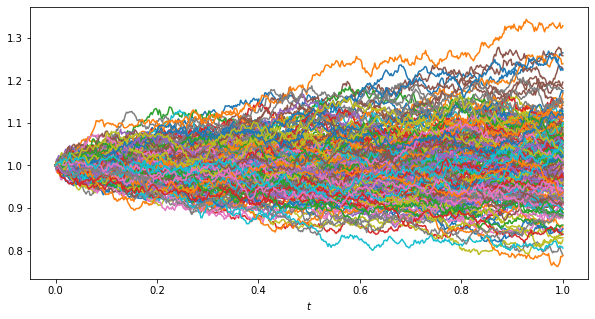

Monte Carlo call price 0.04
Wall time: 78 ms


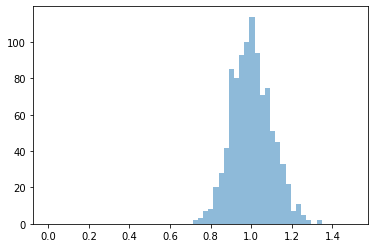

In [94]:
data = pp.Gaussian([500,1000], T=1).to_geometric(0.01, 0.1)
data.plot(num_to_plot=200)
%time c= call_MC(1, data)



In [88]:

def grid_data_gen(strike=1, vol_bounds=(0.05,.55,12), T_bounds=(0.2,4,12), r_bounds=(0, 0.1,12), s_bounds=(0.1,1.9,5)):
    vols = np.linspace(*vol_bounds)
    Ts = np.linspace(*T_bounds)
    rs = np.linspace(*r_bounds)
    data = []
    for vol in tqdm(vols):
        for T in Ts:
            for r in rs:
                p = pp.Gaussian([500,1000], T=T).to_geometric(r, vol)
                c = call_MC(strike, p, verbose=False)
                data.append({"vol": vol, "T":T, "r":r,"call": c})
    return pd.DataFrame(data)

In [89]:
data = grid_data_gen()
features = data.drop(columns=["call"])
labels = data["call"]
data.info()

100%|██████████| 12/12 [01:07<00:00,  5.59s/it]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   vol     1728 non-null   float64
 1   T       1728 non-null   float64
 2   r       1728 non-null   float64
 3   call    1728 non-null   float64
dtypes: float64(4)
memory usage: 54.1 KB


In [83]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [91]:
x_train, x_test, y_train, y_test = train_test_split(features.values, labels.values, test_size=0.2)
call_pricer = RandomForestRegressor(max_depth=4, random_state=1)
call_pricer.fit(x_train, y_train)
print("train score", call_pricer.score(x_train, y_train))
print("test score",call_pricer.score(x_test, y_test))

train score 0.9483104788772839
test score 0.9346141070820301


In [93]:
%time call_pricer.predict([[0.19, 1.54, 0.007]])

Wall time: 18 ms


array([0.10217832])

In [86]:
def call_bs(strike,vol, T, r, spot=1):
    a = (np.log(spot/strike)+(r+vol**2/2.0)*T)/(vol*np.sqrt(T))
    b = a-vol*np.sqrt(T)
    return spot*norm.cdf(a)-strike*np.exp(-r*T)*norm.cdf(b)

In [95]:
%time call_bs(1.0,0.19, 1.54, 0.007)

Wall time: 10 ms


0.09880171242599761